In [5]:
import yfinance as yf
import pandas as pd
import polars as pl
import os
import re
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from io import StringIO
import time
import logging
from linearmodels.panel import PanelOLS
import patsy
import seaborn as sns

Collect scores from hard memory

In [6]:
root = r'C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\data\intersection_scores'

ticker_symbol_pattern = re.compile(r'^([A-Z]+(?:\.[A-Z]+)?)\.parquet$')

df_dict_scores = {}

for dir in os.listdir(root):
    
    match = ticker_symbol_pattern.search(dir)

    ticker = match.group(1)
    ticker = ticker.replace('.', '-')
    print(ticker)

    file_path = os.path.join(root, dir)

    df = pl.read_parquet(file_path)
    df_dict_scores[ticker] = df 

A
AAL
AAPL
ABBV
ABNB
ABT
ACGL
ACN
ADBE
ADI
ADM
ADP
ADSK
AEE
AEP
AES
AFL
AIG
AIZ
AJG
AKAM
ALB
ALGN
ALL
ALLE
AMAT
AMCR
AMD
AME
AMGN
AMP
AMT
AMZN
ANET
ANSS
AON
AOS
APA
APD
APH
APTV
ARE
ATO
AVB
AVGO
AVY
AWK
AXON
AXP
AZO
BA
BAC
BALL
BAX
BBWI
BBY
BDX
BEN
BF-B
BIIB
BIO
BK
BKNG
BKR
BLDR
BLK
BMY
BR
BRK-B
BRO
BSX
BWA
BX
BXP
C
CAG
CAH
CARR
CAT
CB
CBOE
CBRE
CCI
CCL
CDNS
CDW
CE
CEG
CF
CFG
CHD
CHRW
CHTR
CI
CINF
CL
CLX
CMA
CMCSA
CME
CMG
CMI
CMS
CNC
CNP
COF
COO
COP
COR
COST
CPAY
CPB
CPRT
CPT
CRL
CRM
CSCO
CSGP
CSX
CTAS
CTLT
CTRA
CTSH
CTVA
CVS
CVX
CZR
D
DAL
DAY
DD
DE
DECK
DFS
DG
DGX
DHI
DHR
DIS
DLR
DLTR
DOC
DOV
DOW
DPZ
DRI
DTE
DUK
DVA
DVN
DXCM
EA
EBAY
ECL
ED
EFX
EG
EIX
EL
ELV
EMN
EMR
ENPH
EOG
EPAM
EQIX
EQR
EQT
ES
ESS
ETN
ETR
ETSY
EVRG
EW
EXC
EXPD
EXPE
EXR
F
FANG
FAST
FCX
FDS
FDX
FE
FFIV
FI
FICO
FIS
FITB
FMC
FOXA
FRT
FSLR
FTNT
FTV
GD
GE
GEHC
GEN
GILD
GIS
GL
GLW
GM
GNRC
GOOGL
GPC
GPN
GRMN
GS
GWW
HAL
HAS
HBAN
HCA
HD
HES
HIG
HII
HLT
HOLX
HON
HPE
HPQ
HRL
HSIC
HST
HSY
HUBB
HUM
HWM
IBM
ICE
IDXX
IEX
IFF
ILMN
IN

Here I just take calculated previously returns and stuck them with new regressors, which is net_LM, net_HV and intersection dictionaries scors.

In [9]:
root = r'C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\data\snp_500_scores&returns'

dict_for_anal = {}

row_names = pl.Series('row_names', ['net_lm', 'net_hv', 'inter', 'doc_length'])

for company in df_dict_scores:

    scores_df = df_dict_scores[company].hstack([row_names])

    file_path = os.path.join(root, f"{company}.parquet")
    df = pl.read_parquet(file_path)

    df = df.filter(~pl.col('row_names').is_in(["lm_polarity", "lm_raw", "hiv4_polarity", "hiv4_raw", "doc_length"]))

    stacked_df = scores_df.vstack(df)
    
    dict_for_anal[company] = stacked_df

This func is converting date strings in quarter strings 

In [174]:
def convert_to_quarter(date_str):
    date = datetime.strptime(date_str, '%Y-%m-%d')
    quarter = (date.month - 1) // 3 + 1
    formatted_string = f'{date.year}.{quarter}'
    return float(formatted_string)

This function stackes all data in single dataframe 

In [11]:
def get_data_for_FE(dict_for_anal):

    total_df = pl.DataFrame()

    for company in dict_for_anal: 
        row_names = dict_for_anal[company].select(pl.col('row_names')).to_series().to_list()
        
        df = dict_for_anal[company].filter(pl.col("row_names") != 'doc_length')
        row_names.remove('doc_length')
        df = df.select(pl.exclude('row_names'))
    
        quarter_strings = [convert_to_quarter(date) for date in df.columns]
        quarter_strings = pl.Series('date', quarter_strings)
    
        df_w_dates = df.transpose().hstack([quarter_strings])
        df_w_company = df_w_dates.with_columns(pl.lit(company).alias('company'))

        column_name_order = ['company', 'date']
        column_name_order.extend(df.transpose().columns)

        prepared_df = df_w_company.select(column_name_order)
        total_df.vstack(prepared_df, in_place=True)

    total_df_pd = total_df.to_pandas()
   
    col_names =  ['company', 'date']
    col_names.extend(row_names)
   
    total_df_pd.columns = col_names
    total_df_pd = total_df_pd.set_index(['company', 'date'])
    
    return total_df_pd 

In [12]:
df_for_FE = get_data_for_FE(dict_for_anal)

In [13]:
df_for_FE

net_lm    net_hv     inter  eps_surprise     firm_size  \
company date                                                               
A       2019.1 -0.478510  0.500879 -0.431310        0.0402  2.447506e+10   
        2019.2 -0.444142  0.502504 -0.421687        0.1007  2.068122e+10   
        2019.3 -0.446237  0.514356 -0.407855        0.0681  2.119690e+10   
        2019.4 -0.474380  0.561602 -0.267490        0.0119  2.514862e+10   
        2020.1 -0.495327  0.509434 -0.496774        0.1379  2.463511e+10   
...                  ...       ...       ...           ...           ...   
ZTS     2022.4 -0.746753  0.597077 -0.518248        0.1233  6.164240e+10   
        2023.1 -0.652792  0.598630 -0.419820        0.1159  7.942337e+10   
        2023.2 -0.626943  0.616474 -0.333333        0.1081  7.688532e+10   
        2023.3 -0.615385  0.620112 -0.223301           NaN  8.321989e+10   
        2023.4 -0.641256  0.631692 -0.260000           NaN  7.094135e+10   

                day_2_returns  day_3_returns  day_4_returns  day_5_returns  \
company date                                                                 
A       2019.1      -0.332183      -0.007570      -0.124919      -0.059365   
        2019.2       0.228435       0.325175       0.097847      -0.023135   
        2019.3      -0.145456      -0.178184       0.415711       0.473355   
        2019.4       0.347233       0.249660       0.131849       0.068141   
        2020.1       0.487864      -0.072362      -0.961471      -0.331233   
...                       ...            ...            ...            ...   
ZTS     2022.4      -0.624454       0.094380      -0.186674      -0.056747   
        2023.1       0.199565       0.150378       0.175105       0.023997   
        2023.2       4.782784       2.762701       2.303866       1.880381   
        2023.3       2.275646       1.509204       1.327997       0.853788   
        2023.4       3.694695       0.904831       1.496213       1.439562   

                day_6_returns  day_7_returns  full_quarter_returns  
company date                                                        
A       2019.1       0.009627      -0.074499             -0.251560  
        2019.2       0.126015      -0.065167              0.008553  
        2019.3       0.285712       0.508216              0.117632  
        2019.4       0.062336       0.079641              0.015408  
        2020.1      -0.807334      -0.972837              0.155588  
...                       ...            ...                   ...  
ZTS     2022.4       0.110369       0.644938              0.276128  
        2023.1      -0.145746       0.000802             -0.033793  
        2023.2       1.396425       1.172216             -0.023322  
        2023.3       0.771473       0.594399             -0.154471  
        2023.4       1.256715       0.766578                   NaN  

[9830 rows x 12 columns]

Funck to display params 

In [14]:
def extract_params_FE(summary, regressor_name):
    coef_table = summary.tables[1].as_html()
    
    coef_table_io = StringIO(coef_table)
    df = pd.read_html(coef_table_io, header=0, index_col=0)[0]
    
    df.columns = ['Parameter', 'std_err', 'T-stat', 'P-value', 'Lower CI', 'Upper CI']
    #significant_df = df[df['P-value'] < 0.05]

    return df.loc[regressor_name, ['Parameter', 'std_err', 'P-value']].copy()

This is func to fit FE

In [15]:
def fit_FE(df, formula):

    model = PanelOLS.from_formula(formula, data=df)
    #result = model.fit(cov_type='clustered', cluster_entity=True)
    result = model.fit(cov_type='kernel')


    return result.summary

In [17]:
def compute_all_FE(df_for_FE):

    var_names = df_for_FE.columns 
    #print(var_names)
    params_dict = {}
    all_params_dict = {}
    
    for x in range(0, 3):

        signif_params = []
        all_params = []

        for y in range(5, 12):
            data = df_for_FE.iloc[:, [x, 3, 4, y]].dropna().copy()

            formula = f"{var_names[y]} ~ {var_names[x]} + eps_surprise + firm_size + EntityEffects + TimeEffects"
            #print(formula)
            result = fit_FE(data, formula)
            #print(result)
            significant_df = extract_params_FE(result, var_names[x])

            if not significant_df.empty:
                print(f' Dependent var: {var_names[y]} \n Independent var: {var_names[x]} \n Control vars: eps_surprise, firm_size\n')
                print(significant_df, '\n\n\n')
            
            #store all the params in dict
            if significant_df['P-value'] < 0.05:
                
                signif_params.append(significant_df['Parameter'])
            else:
                signif_params.append(0)
            
            all_params.append(significant_df['Parameter'])

        params_dict[var_names[x]] = signif_params
        all_params_dict[var_names[x]] = all_params
    
    return params_dict, all_params_dict    
  
params_dict, all_params_dict = compute_all_FE(df_for_FE)  

 Dependent var: day_2_returns 
 Independent var: net_lm 
 Control vars: eps_surprise, firm_size

Parameter   -0.1433
std_err      0.0256
P-value      0.0000
Name: net_lm, dtype: float64 



 Dependent var: day_3_returns 
 Independent var: net_lm 
 Control vars: eps_surprise, firm_size

Parameter   -0.0975
std_err      0.0239
P-value      0.0000
Name: net_lm, dtype: float64 



 Dependent var: day_4_returns 
 Independent var: net_lm 
 Control vars: eps_surprise, firm_size

Parameter   -0.0949
std_err      0.0237
P-value      0.0001
Name: net_lm, dtype: float64 



 Dependent var: day_5_returns 
 Independent var: net_lm 
 Control vars: eps_surprise, firm_size

Parameter   -0.0809
std_err      0.0208
P-value      0.0001
Name: net_lm, dtype: float64 



 Dependent var: day_6_returns 
 Independent var: net_lm 
 Control vars: eps_surprise, firm_size

Parameter   -0.0774
std_err      0.0181
P-value      0.0000
Name: net_lm, dtype: float64 



 Dependent var: day_7_returns 
 Independent var: n

In [18]:
params_dict

{'net_lm': [-0.1433, -0.0975, -0.0949, -0.0809, -0.0774, -0.091, -0.0453],
 'net_hv': [0.1248, 0.0868, 0.0841, 0.0743, 0.0711, 0.0837, 0.0422],
 'inter': [-0.1557, -0.113, -0.1125, -0.0944, -0.0909, -0.1081, -0.0577]}

In [19]:
all_params_dict

{'net_lm': [-0.1433, -0.0975, -0.0949, -0.0809, -0.0774, -0.091, -0.0453],
 'net_hv': [0.1248, 0.0868, 0.0841, 0.0743, 0.0711, 0.0837, 0.0422],
 'inter': [-0.1557, -0.113, -0.1125, -0.0944, -0.0909, -0.1081, -0.0577]}

In [22]:

def plot_params(data):

    indices = np.arange(len(data['net_lm']))  # Numeric indices for the x-axis
    bar_width = 0.4  # Width of the bars

    # Create figure and two subplots
    plt.figure(figsize=(6, 6))

    plt.bar(indices, data['net_hv'], width=bar_width, label='net HIV4 dictionary', color='sandybrown')
    plt.bar(indices - bar_width/2, data['net_lm'], width=bar_width, label='net LM dictionary', color='skyblue')
    plt.bar(indices + bar_width/2, data['inter'], width=bar_width, label='intersection dictionary', color='tab:green')
    plt.axhline(0, color='black', linewidth=1)  # Add horizontal line at y=0
    plt.title('Net LM, HIV4 and Intersection scores coefficients')
    plt.xlabel('Returns time frame')
    plt.ylabel('Beta coefficients from fixed effects')
    plt.xticks(indices, ['2_day', '3_day', '4_day', '5_day', '6_day', '7_day', 'full_quarter'])
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

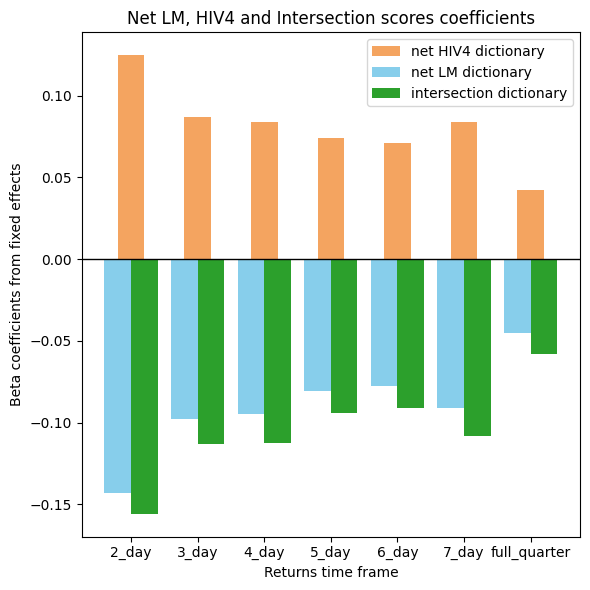

In [23]:
plot_params(all_params_dict)

Now because of ambiguity of the effect of separation of dictionaries I am going to inspect the relationships between them directly. 

Here i create a df with all scores: lm_polarity, hv_polarity, net_lm, net_hv, inter scores. (I exclude raw scores, bc they are insignificant).

In [175]:
root = r'C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\data\snp_500_scores&returns'

regressors_dict = {}

row_names = pl.Series('row_names', ['net_lm', 'net_hv', 'inter', 'doc_length'])

for company in df_dict_scores:

    scores_df = df_dict_scores[company].hstack([row_names])
    scores_df = scores_df.filter(pl.col('row_names') != 'doc_length')

    file_path = os.path.join(root, f"{company}.parquet")
    df = pl.read_parquet(file_path)

    df = df.filter(pl.col('row_names').is_in(["lm_polarity", "hiv4_polarity",]))

    stacked_df = scores_df.vstack(df)
    
    regressors_dict[company] = stacked_df



In [176]:
regressors_dict

{'A': shape: (5, 21)
 ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
 │ 2019-03-0 ┆ 2019-05-3 ┆ 2019-08-3 ┆ 2019-12-1 ┆ … ┆ 2023-05-2 ┆ 2023-08-3 ┆ 2023-12-2 ┆ row_name │
 │ 5         ┆ 0         ┆ 0         ┆ 9         ┆   ┆ 6         ┆ 1         ┆ 0         ┆ s        │
 │ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
 │ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ str      │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
 │ -0.47851  ┆ -0.444142 ┆ -0.446237 ┆ -0.47438  ┆ … ┆ -0.505051 ┆ -0.606796 ┆ -0.520216 ┆ net_lm   │
 │ 0.500879  ┆ 0.502504  ┆ 0.514356  ┆ 0.561602  ┆ … ┆ 0.5       ┆ 0.515055  ┆ 0.568794  ┆ net_hv   │
 │ -0.43131  ┆ -0.421687 ┆ -0.407855 ┆ -0.26749  ┆ … ┆ -0.512329 ┆ -0.524064 ┆ -0.437722 ┆ inter    │
 │ -0.329588 ┆ -0.321787 ┆ -0.32539  ┆ -0.266055 ┆ … ┆ -0.391

In [27]:
def convert_to_quarter(date_str):
    date = datetime.strptime(date_str, '%Y-%m-%d')
    quarter = (date.month - 1) // 3 + 1
    formatted_string = f'{date.year}.{quarter}'
    return float(formatted_string)

In [177]:
def create_total_df(regressors_dict):
        total_df = pl.DataFrame()

        for company in regressors_dict: 
                row_names = regressors_dict[company].select(pl.col('row_names')).to_series().to_list()

                df = regressors_dict[company].select(pl.exclude('row_names'))
        
                quarter_strings = [convert_to_quarter(date) for date in df.columns]
                quarter_strings = pl.Series('date', quarter_strings)
        
                df_w_dates = df.transpose().hstack([quarter_strings])
                df_w_company = df_w_dates.with_columns(pl.lit(company).alias('company'))

                column_name_order = ['company', 'date']
                column_name_order.extend(df.transpose().columns)

                prepared_df = df_w_company.select(column_name_order)
                total_df.vstack(prepared_df, in_place=True)

        total_df_pd = total_df.to_pandas()
        
        col_names =  ['company', 'date']
        col_names.extend(row_names)

        total_df_pd.columns = col_names
        total_df_pd = total_df_pd.set_index(['company', 'date'])

        return total_df_pd

total_df_pd = create_total_df(regressors_dict)

In [178]:
std_dict = {}

for col in total_df_pd:
    std_dict[col] = total_df_pd[col].std()

std_dict

{'net_lm': 0.17372877272514545,
 'net_hv': 0.08331382200871165,
 'inter': 0.20235773879166052,
 'lm_polarity': 0.14956229525566428,
 'hiv4_polarity': 0.07323667886736741}

In [179]:
chang_std_lm = (std_dict["net_lm"] - std_dict["lm_polarity"]) / std_dict['lm_polarity']
chang_std_hv = (std_dict["net_hv"] - std_dict["hiv4_polarity"]) / std_dict['hiv4_polarity']

print(f'Change in std for LM: {chang_std_lm} \nChange in std for HV: {chang_std_hv}')

Change in std for LM: 0.1615813492843941 
Change in std for HV: 0.13759694318736213


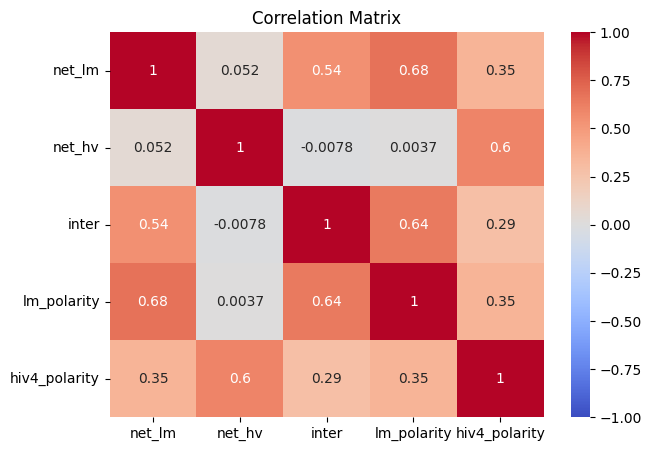

In [180]:
def plot_corr_matrix(df):

    corr_matrix = df.corr()
    plt.figure(figsize=(7, 5))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix')
    plt.show()

plot_corr_matrix(total_df_pd)

Let's try to get the data that we actually use in FE model. Subtruct time means and entyty means.

In [181]:
def create_FE_data(dataframe):

    company_means = {}
    for company, group in dataframe.groupby(level="company"):
        company_means[company] = group.mean()
        

    date_means = {}
    for date, group in dataframe.groupby(level="date"):
        date_means[date] = group.mean()

    result_df = dataframe.copy()
    
    for company, group in result_df.groupby(level="company"):
        result_df.loc[company] = group - company_means[company]

    result_df2 = result_df.copy()

    for date, group in result_df2.groupby(level="date"):
        result_df2.loc[(slice(None), date), :] = group - date_means[date]

    return result_df2

fe_df = create_FE_data(total_df_pd)


In [169]:
fe_df

net_lm    net_hv     inter  lm_polarity  hiv4_polarity
company date                                                            
A       2019.1  0.608027 -0.604543  0.433863     0.285411      -0.509658
        2019.2  0.611278 -0.613020  0.451460     0.296483      -0.552648
        2019.3  0.615414 -0.597320  0.461089     0.299824      -0.523197
        2019.4  0.595222 -0.554832  0.596438     0.361065      -0.461734
        2020.1  0.612097 -0.600609  0.391157     0.315633      -0.474195
...                  ...       ...       ...          ...            ...
ZTS     2022.4  0.501896 -0.607282  0.392812     0.247914      -0.511928
        2023.1  0.619154 -0.610383  0.499609     0.346604      -0.475040
        2023.2  0.619545 -0.591887  0.586416     0.342776      -0.470736
        2023.3  0.630994 -0.584918  0.675105     0.353769      -0.471489
        2023.4  0.620521 -0.572397  0.631262     0.373145      -0.472423

[9830 rows x 5 columns]

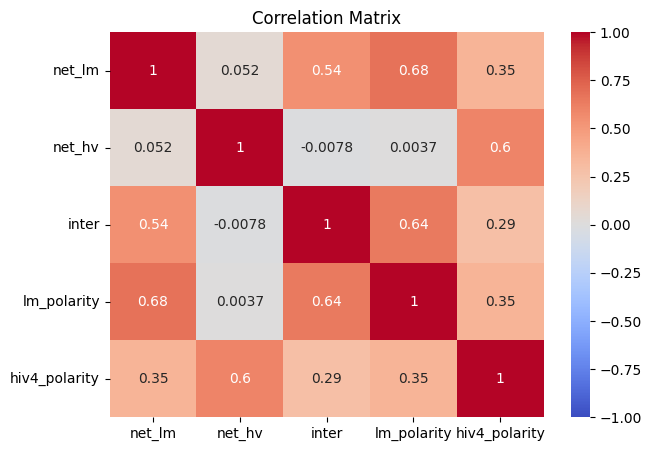

In [183]:
plot_corr_matrix(total_df_pd)

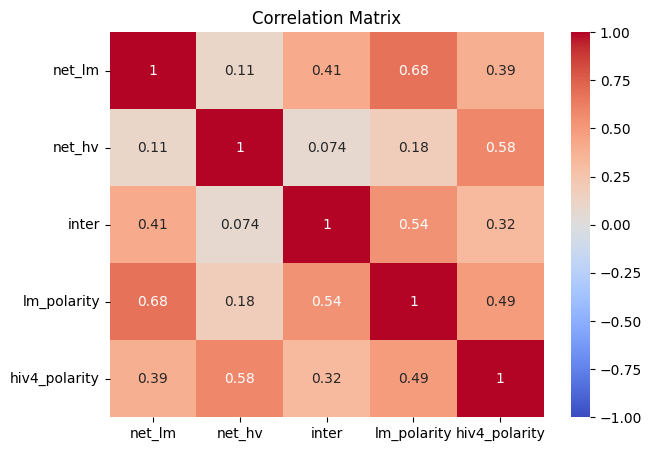

In [184]:
plot_corr_matrix(fe_df)

jupyter nbconvert --to html Parsim-sec\src\Analysis\intersection_returns.ipynb